<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [34]:
!pip install --upgrade mxnet~=1.7 gluonts

In [3]:
df = pd.read_csv('/content/EURUSD_M1_202001020600_202201130331.csv')


In [4]:
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [5]:
df

,0,1,2,3,4,5,6,7,8
0,2020.01.02,06:00:00,1.12132,1.12133,1.12128,1.12131,14,0,3
1,2020.01.02,06:01:00,1.12131,1.12133,1.12131,1.12132,16,0,4
2,2020.01.02,06:02:00,1.12132,1.12133,1.12131,1.12132,9,0,3
3,2020.01.02,06:03:00,1.12132,1.12134,1.12132,1.12132,19,0,3
4,2020.01.02,06:04:00,1.12132,1.12133,1.12132,1.12132,3,0,4
...,...,...,...,...,...,...,...,...,...
757186,2022.01.12,15:26:00,1.13720,1.13721,1.13696,1.13697,40,0,0
757187,2022.01.12,15:27:00,1.13696,1.13705,1.13689,1.13703,68,0,0
757188,2022.01.12,15:28:00,1.13702,1.13702,1.13687,1.13687,38,0,0
757189,2022.01.12,15:29:00,1.13687,1.13687,1.13666,1.13680,92,0,0


In [6]:
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                 0         1        5
0       2020.01.02  06:00:00  1.12131
1       2020.01.02  06:01:00  1.12132
2       2020.01.02  06:02:00  1.12132
3       2020.01.02  06:03:00  1.12132
4       2020.01.02  06:04:00  1.12132
...            ...       ...      ...
757186  2022.01.12  15:26:00  1.13697
757187  2022.01.12  15:27:00  1.13703
757188  2022.01.12  15:28:00  1.13687
757189  2022.01.12  15:29:00  1.13680
757190  2022.01.12  15:30:00  1.13654

[757191 rows x 3 columns]


In [7]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [8]:
new_df = new_df.rename(columns={5:'price'})

In [26]:
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2020-01-02 06:00:00  1.12131
2020-01-02 06:01:00  1.12132
2020-01-02 06:02:00  1.12132
2020-01-02 06:03:00  1.12132
2020-01-02 06:04:00  1.12132
...                      ...
2022-01-12 15:26:00  1.13697
2022-01-12 15:27:00  1.13703
2022-01-12 15:28:00  1.13687
2022-01-12 15:29:00  1.13680
2022-01-12 15:30:00  1.13654

[757191 rows x 1 columns]


In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757191 entries, 2020-01-02 06:00:00 to 2022-01-12 15:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   757191 non-null  float64
dtypes: float64(1)
memory usage: 11.6 MB


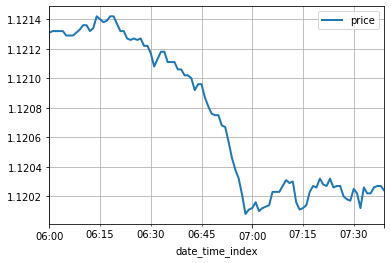

In [28]:
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [35]:
from gluonts.dataset.common import ListDataset

In [37]:
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-01-01 00:00:00"]}], 
    freq = "1min"
    )

In [38]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
estimator = DeepAREstimator(freq="1min", prediction_length=480, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

  8%|▊         | 4/50 [00:10<01:55,  2.51s/it, epoch=5/10, avg_epoch_loss=-3.04]

In [ ]:
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-01-12 01:00:00"]}],
    freq = "1min"
)

from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')